In [1]:
import pyarabic.araby as araby
import re
import string
import unicodedata as ud
import codecs
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tashaphyne.stemming import ArabicLightStemmer
from itertools import islice
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

In [4]:
######### GET DATA ##############
#Call stop words 
def get_stop_words():
    path = "C:\\Users\\asus\\Desktop\\stop_words.txt"
    stop_words = []
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        stop_words = myfile.readlines()
    stop_words = [word.strip() for word in stop_words]
    return stop_words
#Call pos emojis 
def get_emojis():
    with codecs.open("C:\\Users\\asus\\Desktop\\emoji.txt", "r", encoding="utf-8", errors="ignore") as myfile:
         positive_emoji=myfile.read()
    positive_emoji=positive_emoji.split("\r\n")
    positive_emoji=positive_emoji[1:len(positive_emoji)-1] 
    with codecs.open("C:\\Users\\asus\\Desktop\\neg_emoji.txt", "r", encoding="utf-8", errors="ignore") as myfie:
        neg_emoji=myfie.read()
    neg_emoji=neg_emoji.split("\r\n")
    neg_emoji=neg_emoji[1:len(neg_emoji)-1]
    return positive_emoji,neg_emoji
    

#get data , Text vs label
def get_data():
    path="C:\\Users\\asus\\Desktop\\data.txt"
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        text = myfile.read()
    sentences=text.split("@")
    sentences=[x.split("\r\n") for x in sentences]
    sentences=sentences[1:len(sentences)-1]
    df=pd.DataFrame(sentences)
    df.columns = ['sentiment','sentence']
    return df

############## PREPROCESSING DATA ################
#Remove stop words 
def remove_stp_words(text):
    text_words = []
    words = text.split(" ")
    stop_words = get_stop_words()
    for word in words:
        if word not in stop_words:
            text_words.append(word)
    return ' '.join(text_words)
#Emoticons_Regex 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
regex_str = [
    emoticons_str,
    r'<[^>]+>',  # HTML tags
    r'(?:@[\w_]+)',  # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",  # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',  # URLs

    r'(?:(?:\d+,?)+(?:\.?\d+)?)',  # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])",  # words with - and '
    r'(?:[\w_]+)',  # other words
    r'(?:\S)'  # anything else
]
tokens_re = re.compile(r'(' + '|'.join(regex_str) + ')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^' + emoticons_str + '$', re.VERBOSE | re.IGNORECASE)
#Tokenizing_the_text :
def tokenize(s):
    return tokens_re.findall(s)
#Normalize_the_text:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text
#Remove-repeating_char :
def remove_repeating_char(text):
     #return re.sub(r'(.)\1+', r'\1', text)     # keep only 1 repeat
    return re.sub(r'(.)\1+', r'\1\1', text)     # keep 2 repeat
#Detecting_Emojis_REGEX
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)
#Transform_emojis-to_sentiment 
def emoji_to_text(text):
    text_words = []
    words = text.split(" ")
    positive_emoji,neg_emoji=get_emojis()
    for word in words:
        if emoji_pattern.search(word):
            if word in positive_emoji :
                word='ايجابي'
            if word in neg_emoji :
                word='سلبي'
        text_words.append(word)
    return ' '.join(text_words)
#REMOVING_Punctuation
def remove_punc(text):
    return ''.join(c for c in text if not ud.category(c).startswith('P'))

#Stemmer_LIGHT :
ArListem = ArabicLightStemmer()
def stemmer_light(text):
    text_words = []
    words = text.split(" ")
    for c in words:
        stem = ArListem.light_stem(c)
        text_words.append(stem)
    return ' '.join(text_words)
#Stemmer_root:
def stemmer_root(text):
    text_words = []
    words = text.split(" ")
    for c in words:
        stem = ArListem.light_stem(c)
        text_words.append(stem)
    return ' '.join(text_words)
def correct(text):
    #T=TextCorrection()
    words = text.split(" ")
    text_words = []
    for word in words :
        text_words.append(T.correction(word,top=True))
    return ' '.join(text_words)
############ ARABIC TEXT PREPROCESSIG #########
def data_clean(stp_words=False,stem=True,tok=True,emojis=False):
    data = get_data()
    sentences = data['sentence']
    sentences = [araby.strip_tatweel(text) for text in sentences]
    sentences = [remove_punc(text) for text in sentences]
    if emojis==False :
        sentences = [emoji_to_text(text) for text in sentences] 
    sentences = [remove_repeating_char(text) for text in sentences]
    sentences = [araby.strip_tashkeel(text) for text in sentences]
    if stp_words==True :
        sentences = [remove_stp_words(text) for text in sentences]
    #sentences = [correct(text) for text in sentences]
    if stem==True:
        sentences = [stemmer_light(text) for text in sentences]
    sentences = [normalize_arabic(text) for text in sentences]
    sentences = [araby.normalize_hamza(text) for text in sentences]
    if tok==True:
        sentences = [tokenize(text) for text in sentences]
    return sentences         

<BarContainer object of 2 artists>

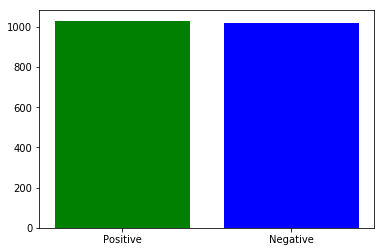

In [7]:
######## TF_IDF ############
def get_tfidf():
    data = data_clean(stp_words=True,stem=False,tok=False,emojis=False)
    vectorizer = TfidfVectorizer(ngram_range = (1,1))
    X = vectorizer.fit_transform(data)
    return X
########## Document-Term Matrix(DTM) ######
def doc_term_frec():
    data = data_clean(stp_words=True,stem=False,tok=False,emojis=False)
    cv = CountVectorizer(ngram_range = (1,1))
    X= cv.fit_transform(data)
    return X

plt.bar(["Positive","Negative"],[sentiment[sentiment=='P'].count(),sentiment[sentiment=='N'].count()],color=['g','b']) 

In [6]:
data_set =get_data()
sentiment = data_set['sentiment']
sentimen =np.array( [1 if sen == 'P' else 0 for sen in sentiment])
X_train, X_test, y_train, y_test = train_test_split(doc_term_frec(), sentimen, test_size=0.2, random_state=1)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1642, 9112) (1642,)
(411, 9112) (411,)


In [8]:
clf = MultinomialNB(alpha=0.1, fit_prior= False).fit(X_train, y_train)
log = LogisticRegression( solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)                                                                    
d_tree = tree.DecisionTreeClassifier().fit(X_train,y_train)
svm = LinearSVC().fit(X_train,y_train)
print(classification_report( log.predict(X_test) , y_test))
print("Logistic Regression:",accuracy_score( log.predict(X_test) , y_test ),accuracy_score( log.predict(X_train) , y_train ))
print(classification_report( d_tree.predict(X_test) , y_test))
print("Decision Tree Accuracy:",accuracy_score( d_tree.predict(X_test) , y_test ),accuracy_score( d_tree.predict(X_train) , y_train ))
print(classification_report( clf.predict(X_test) , y_test))
print("MultinomialNB Accuracy:",accuracy_score( clf.predict(X_test) , y_test ),accuracy_score( clf.predict(X_train) , y_train ))
print(classification_report( svm.predict(X_test) , y_test))
print("SVM Accuracy:",accuracy_score( svm.predict(X_test) , y_test ),accuracy_score( svm.predict(X_train) , y_train ))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       192
           1       0.87      0.77      0.82       219

    accuracy                           0.82       411
   macro avg       0.82      0.82      0.82       411
weighted avg       0.82      0.82      0.82       411

Logistic Regression: 0.8175182481751825 0.9987819732034104
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       248
           1       0.66      0.79      0.72       163

    accuracy                           0.76       411
   macro avg       0.75      0.76      0.75       411
weighted avg       0.77      0.76      0.76       411

Decision Tree Accuracy: 0.7591240875912408 0.9993909866017052
              precision    recall  f1-score   support

           0       0.73      0.87      0.79       182
           1       0.88      0.74      0.80       229

    accuracy                           0.80       411
   macr

In [6]:
rand_forest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0).fit(X_train,y_train)
adaboost = AdaBoostClassifier(n_estimators=800,learning_rate=0.009,random_state=0).fit(X_train,y_train)
print(classification_report( rand_forest.predict(X_test) , y_test))
print("Random Forest:",accuracy_score( rand_forest.predict(X_test) , y_test ),accuracy_score( rand_forest.predict(X_train) , y_train ))
print(classification_report( adaboost.predict(X_test),y_test))
print("Adaboost:",accuracy_score( adaboost.predict(X_test) , y_test ),accuracy_score( adaboost.predict(X_train) , y_train ))

              precision    recall  f1-score   support

           0       0.98      0.65      0.78       288
           1       0.53      0.97      0.68       118

   micro avg       0.74      0.74      0.74       406
   macro avg       0.75      0.81      0.73       406
weighted avg       0.85      0.74      0.75       406

Random Forest: 0.7413793103448276 0.7925925925925926
              precision    recall  f1-score   support

           0       0.99      0.61      0.76       309
           1       0.45      0.99      0.62        97

   micro avg       0.70      0.70      0.70       406
   macro avg       0.72      0.80      0.69       406
weighted avg       0.86      0.70      0.73       406

Adaboost: 0.7044334975369458 0.7327160493827161
